In [1]:
import numpy as np
from ripser import Rips
import matplotlib.pyplot as plt
from get_hdmatrices import TARG

## Data Preprocessing

In [2]:
targ = TARG(samples=100, simulations=1, groups=1, segsites=1000, maxdim=2)

# File Processing
# (SIMULATIONS, SAMPLES)
group = targ.get_sample_sequences("sim_073024.txt")

# Hamming Distance Matrix Computation
# (SIMULATIONS, SAMPLES, SAMPLES)
hdmatrices = targ.get_hdmatrices(group)

# Add Stochasticity Computation
# (VARLIST, SIMULATIONS, SAMPLES, SAMPLES)
varlist = targ.add_stochasticity(hdmatrices)

In [3]:
hdmatrices[0].shape

(100, 100)

## Topological Quantities


### Persistence Diagram

Homologies      contains a list of three entries
                each entry is a record of birth and death times
                of each homology group ($H_0, H_1, H_2$)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


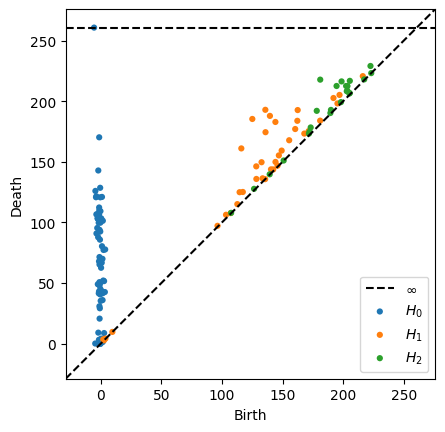

In [4]:
rips = Rips(maxdim=targ.MAXDIM, do_cocycles=True)

# Show the persistence diagram
homologies = []

# TODO: Fix to get all simulations, currently only gets the 1st simulation
# GOAL: homologies of dimension (VARLIST, SIMULATIONS, MAXDIM+1, X)
for v in varlist:
    homologies.append(rips.fit_transform(v[0], distance_matrix=True))

# For testing purposes only
hom = homologies[20]
rips.plot(hom, show=True)

In [5]:
# Compute Betti Numbers
betti_numbers = targ.get_betti_numbers(hom)

# Compute Barcode Lengths
barcode_lens = targ.get_barcode_lengths(hom)

# Compute Barcode Means and Variances
barcode_means, barcode_vars = targ.get_barcode_length_statistics(hom)

c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [6]:
homologies[0][0]

array([[  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       [  0.,   2.],
       [  0.,   2.],
       [  0.,   2.],
       [  0.,   2.],
       [  0.,   2.],
       [  0.,   3.],
       [  0.,   3.],
       [  0.,   4.],
       [  0.,   4.],
       [  0.,  11.],
       [  0.,  12.],
       [  0.,  23.],
       [  0.,  30.],
       [  0.,  36.],
       [  0.,  36.],
       [  0.,  39.],
       [  0.,  42.],
       [  0.,  43.],
       [  0.,  43.],
       [  0.,  44.],
       [  0.,  45.],
       [  0.,  46.],
       [  0.,  46.],
       [  0.,  49.],
       [  0.,  50.],
       [  0.,  52.],
       [  0.,  52.],
       [  0.,  53.],
       [  0.,  54.],
       [  0.,  63.],
       [  0.,  64.],
       [  0.,  67.],
       [  0.,

### Barcode Ensemble Diagrams

c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\function_base.py:168: RuntimeWarning: invalid value encountered in multiply
  y *= step


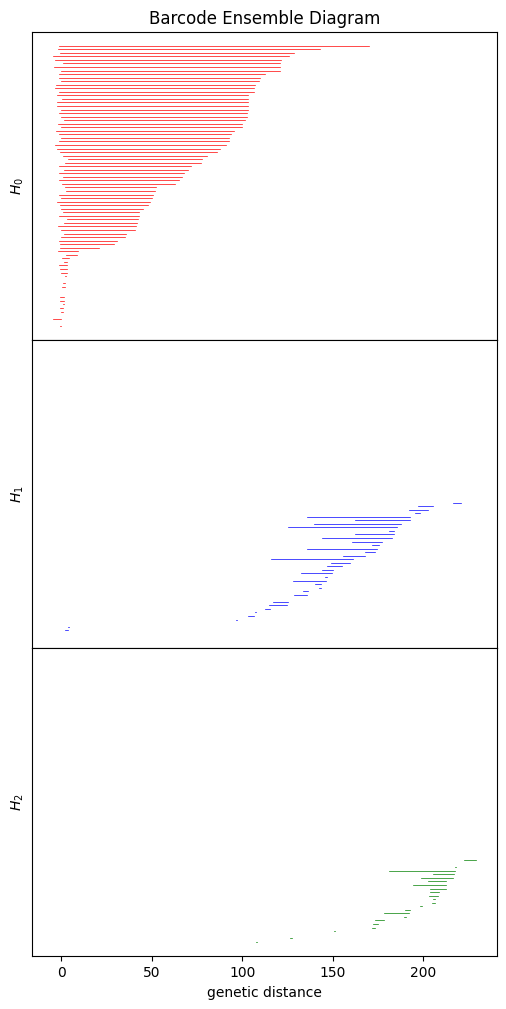

In [7]:
fig = plt.figure(figsize=(6,12))
gs = fig.add_gridspec(nrows=3,hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

colors=['r', 'b', 'g']
labels=['$H_0$','$H_1$', '$H_2$']

for i in range(0, betti_numbers.shape[0]):
    axs[i].set_ylabel(labels[i])
    axs[i].get_yaxis().set_ticks([])
    axs[i].label_outer()

    len_h = round(betti_numbers[i])
    for j in range(0, len_h):
        axs[i].plot(np.linspace(hom[i][j][0], hom[i][j][1], 2), [j, j], c=colors[i], linewidth=0.5)
    
axs[0].set_title("Barcode Ensemble Diagram")
axs[-1].set_xlabel("genetic distance")
plt.show()

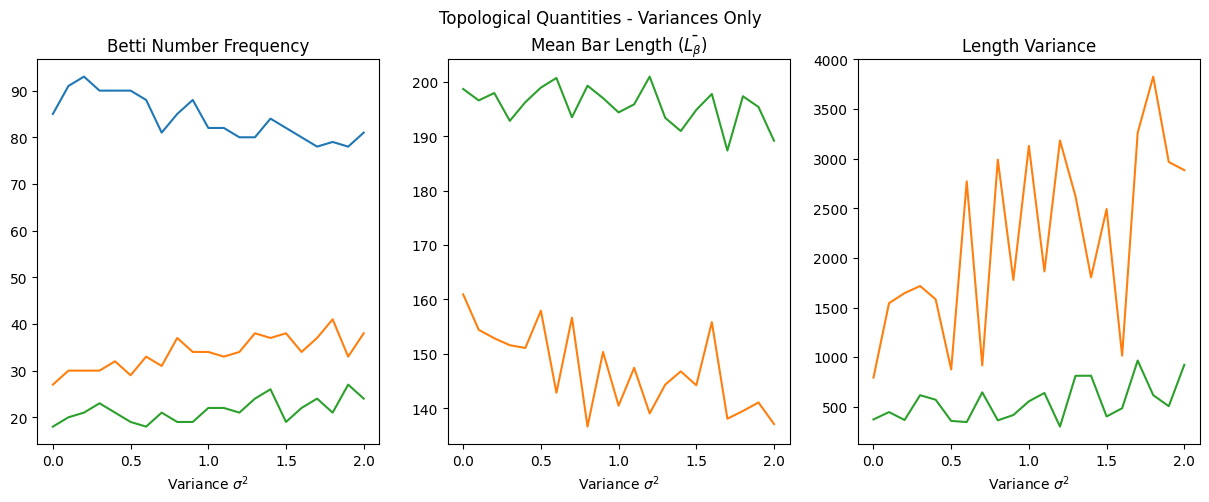

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Generate plot for Betti numbers of different variances
var_values = [round(x / 10, 2) for x in range(0,21)]
var_betti_numbers = np.empty((len(var_values), targ.MAXDIM + 1))
mean_barcode_lengths = np.empty((len(var_values),targ.MAXDIM + 1))
variance_barcode_lengths = np.empty((len(var_values), targ.MAXDIM + 1))

for i in range(0, len(var_values)):
    var_betti_numbers[i] = targ.get_betti_numbers(homologies[i])
    mean_barcode_lengths[i], variance_barcode_lengths[i] = targ.get_barcode_length_statistics(homologies[i])

# y1, y2, y3
var_betti_numbers = var_betti_numbers.T
mean_barcode_lengths = mean_barcode_lengths.T
variance_barcode_lengths = variance_barcode_lengths.T

fig.suptitle("Topological Quantities - Variances Only")

axs[0].plot(var_values, var_betti_numbers[0, :], label="Betti Number $\\beta_0$")
axs[0].plot(var_values, var_betti_numbers[1, :], label="Betti Number $\\beta_1$")
axs[0].plot(var_values, var_betti_numbers[2, :], label="Betti Number $\\beta_2$")
axs[0].set_title("Betti Number Frequency")
axs[0].set(xlabel="Variance $\\sigma^2$")

axs[1].plot(var_values, mean_barcode_lengths[0, :], label="Mean Barcode Length $H_0$")
axs[1].plot(var_values, mean_barcode_lengths[1, :], label="Mean Barcode Length $H_1$")
axs[1].plot(var_values, mean_barcode_lengths[2, :], label="Mean Barcode Length $H_2$")
axs[1].set_title("Mean Bar Length ($\\bar{L_\\beta}$)")
axs[1].set(xlabel="Variance $\\sigma^2$")

axs[2].plot(var_values, variance_barcode_lengths[0, :], label="Barcode Length Variance $H_0$")
axs[2].plot(var_values, variance_barcode_lengths[1, :], label="Barcode Length Variance $H_1$")
axs[2].plot(var_values, variance_barcode_lengths[2, :], label="Barcode Length Variance $H_2$")
axs[2].set_title("Length Variance")
axs[2].set(xlabel="Variance $\\sigma^2$")

plt.show()

## With Sparsity

In [9]:
# (SIMULATIONS, SPARSITY, SAMPLES, SEGSITES)
sparse_group_samples = targ.sparsity_sampling(group)

In [10]:
sparsity_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sparse_hdmatrices = []

for i in range(0, len(sparsity_list)):
    targ.SAMPLES = int(targ.SAMPLES * sparsity_list[i])
    sparse_hdmatrices.append(targ.get_hdmatrices([sparse_group_samples[i]]))
    targ.SAMPLES = 100

In [11]:
sparse_homologies = []
for sp in sparse_hdmatrices:
    sparse_homologies.append(rips.fit_transform(sp[0], distance_matrix=True))

sp_hom = sparse_homologies[3]

In [12]:
sparse_betti_numbers = targ.get_betti_numbers(sp_hom)

# Compute Barcode Lengths
sparse_barcode_lens = targ.get_barcode_lengths(sp_hom)

# Compute Barcode Means and Variances
sparse_barcode_means, sparse_barcode_vars = targ.get_barcode_length_statistics(sp_hom)

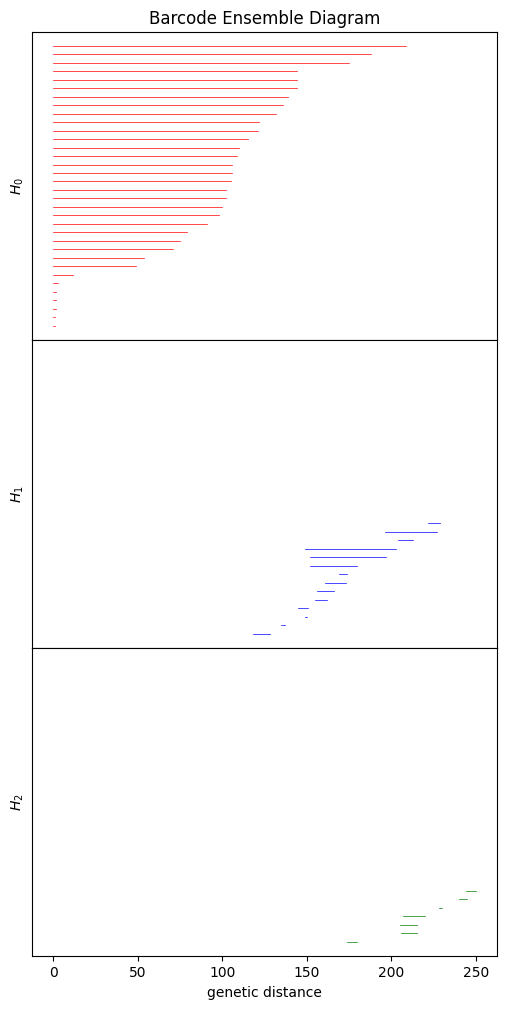

In [13]:
fig = plt.figure(figsize=(6,12))
gs = fig.add_gridspec(nrows=3,hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

colors=['r', 'b', 'g']
labels=['$H_0$','$H_1$', '$H_2$']

for i in range(0, sparse_betti_numbers.shape[0]):
    axs[i].set_ylabel(labels[i])
    axs[i].get_yaxis().set_ticks([])
    axs[i].label_outer()

    len_h = round(sparse_betti_numbers[i])
    for j in range(0, len_h):
        axs[i].plot(np.linspace(sp_hom[i][j][0], sp_hom[i][j][1], 2), [j, j], c=colors[i], linewidth=0.5)
    
axs[0].set_title("Barcode Ensemble Diagram")
axs[-1].set_xlabel("genetic distance")
plt.show()

c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\AnacondaDestination\envs\targ\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


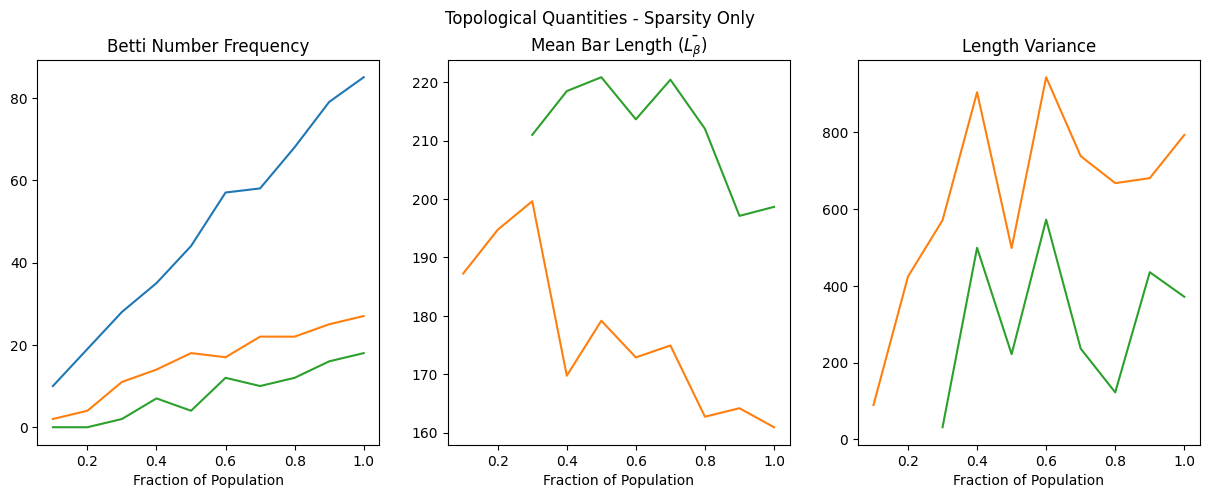

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Generate plot for Betti numbers of different variances
sparse_var_betti_numbers = np.empty((len(sparsity_list), targ.MAXDIM + 1))
sparse_mean_barcode_lengths = np.empty((len(sparsity_list),targ.MAXDIM + 1))
sparse_variance_barcode_lengths = np.empty((len(sparsity_list), targ.MAXDIM + 1))

for i in range(0, len(sparsity_list)):
    sparse_var_betti_numbers[i] = targ.get_betti_numbers(sparse_homologies[i])
    sparse_mean_barcode_lengths[i], sparse_variance_barcode_lengths[i] = targ.get_barcode_length_statistics(sparse_homologies[i])

# y1, y2, y3
sparse_var_betti_numbers = sparse_var_betti_numbers.T
sparse_mean_barcode_lengths = sparse_mean_barcode_lengths.T
sparse_variance_barcode_lengths = sparse_variance_barcode_lengths.T

fig.suptitle("Topological Quantities - Sparsity Only")

axs[0].plot(sparsity_list, sparse_var_betti_numbers[0, :], label="Betti Number $\\beta_0$")
axs[0].plot(sparsity_list, sparse_var_betti_numbers[1, :], label="Betti Number $\\beta_1$")
axs[0].plot(sparsity_list, sparse_var_betti_numbers[2, :], label="Betti Number $\\beta_2$")
axs[0].set_title("Betti Number Frequency")
axs[0].set(xlabel="Fraction of Population")

axs[1].plot(sparsity_list, sparse_mean_barcode_lengths[0, :], label="Mean Barcode Length $H_0$")
axs[1].plot(sparsity_list, sparse_mean_barcode_lengths[1, :], label="Mean Barcode Length $H_1$")
axs[1].plot(sparsity_list, sparse_mean_barcode_lengths[2, :], label="Mean Barcode Length $H_2$")
axs[1].set_title("Mean Bar Length ($\\bar{L_\\beta}$)")
axs[1].set(xlabel="Fraction of Population")

axs[2].plot(sparsity_list, sparse_variance_barcode_lengths[0, :], label="Barcode Length Variance $H_0$")
axs[2].plot(sparsity_list, sparse_variance_barcode_lengths[1, :], label="Barcode Length Variance $H_1$")
axs[2].plot(sparsity_list, sparse_variance_barcode_lengths[2, :], label="Barcode Length Variance $H_2$")
axs[2].set_title("Length Variance")
axs[2].set(xlabel="Fraction of Population")

plt.show()

In [17]:
sparse_variance_barcode_lengths

array([[         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [ 89.1875    , 424.4375    , 571.23140496, 904.90178571,
        498.63888889, 944.0449827 , 738.33626033, 667.92561983,
        680.9476    , 793.55006859],
       [         nan,          nan,  31.5       , 499.25      ,
        221.859375  , 572.72222222, 236.4475    , 122.28993056,
        435.671875  , 371.61111111]])